# Notebook 1 - Backtesting
## Opening Range Algorithmic Trading Example
### Version 0.3.1
#### 06/25/2025
_____________________________________________________________________________________________________________________________________________________________________


## Strategy Summary
This is an entry level trading strategy based on an opening range breakout. This algorithm is not designed to generate alpha. It is designed to demonstarte my skillset in software engineering, backesting, machine learning and financial analysis. I want to measure a high and low and if the price breaks the high, we take it for a price target, if the price breaks the low we take it for a price target. 

If the first trade fails, we will give it a second chance if it retriggers. The risk is the low of the operning range bar. Previous iterations of backtesting have looked to optimize profit targets and determined the contracts to be traded. For clarity, we will only include two contracts here for comparison. The Micro NASDAQ (MNQ) and Micro S&P 500 (MES) futures contracts. 

We will create a full backtest and then exprot that data to an intermediate CSV file that we can use for further assessment using machine learning techniques in additional notebooks. All data has been gathered from Interactive Brokers using the IBKR API.

## Section 1: Importing Libraries
It is important to note that this notebook uses a private internal library 'River Rose'. Code is not provided publicly for compliance and security reasons.

### Importing Libraries

In [1]:
#import our libraries
import numpy as np
import pandas as pd
import RiverRose as rr
import RiverRose.technical_analysis as rrt
import RiverRose.kpi as rrk
import RiverRose.graphing as rrg
import sqlalchemy as pg
import matplotlib.pyplot as plt

We currently don't need to bring in any tradingApp classes from interactive brokers as we will just be working with historical data for our backtesting. Our historical data was gathered from our postgreSQL database hosted on AWS RDS which is continuously updated using the IBKR API. 
We will be using this data to build the technical indicators and trade signals allowing us to test the logic in the strategies.

## Section 2: Dynamic Variables
Let's also take a second to bring in the dynamic variables that we can change for a quick run to see how differing strategies work. In the published version of this notebook, we will only be using the MNQ and MES futures. We will be calculating a fixed return (not continuous compounding) implying no reinvestment. We are only trading a static single contract in this strategy. We will be demonstrating results based on a 5' opening range brekaout. Our profit target will be 2 times the risk on the trade. The risk will be dynamic on the day. If we want to reduce risk, we can code in a maximum risk per day if the 5' opening range is too large but for now, we will assume that we can accept the risk.

In [2]:
#Asset class that I want to test
asset = 'Futures'

#Prompt the user for their database password
database = input("Type the name of your database: ")
username = input("Type your database username: ") 
password = input("Type your database password: ")
host = input("Type the URL of your database: ")


#create a list of our tickers so we can iterate
if asset == 'Futures':
    tickers = ['mes','mnq'] #Futures
elif asset == 'Stock':
    tickers = None #Equities

# Return Type (is it compound or fixed return)
return_type = 'fixed'

#Time frame of the opening range breakout
orb_time = '5min'

#size of bars for KPI calculations
size_of_bar = 5 #integer of minutes per bar

#Easily adjust our profit target multiplier to test
profit_multiplier = 2

## Section 3: Explanation of Derivatives
We will be using the Front Month Micro Futures contracts to show the strategy with minimal risk. 'Front month' means that we will be using the contract with the nearest expiry, rolling over to the next expiry before the risk of the contract closing and 'taking delivery' approaches. The risk can be increased depending on the value of the portfolio being used. Moving up to the Mini Futures contracts will roughly increase profits and losses by 10x. If trading multiple micro contracts, it may be a good idea to step up to the mini contracts to avoid excessive transaction fees that are based per contract.

### Dollar Value of Futures Contracts

|Contract| 1-Point | 1 Tick| Margin (Variable) |
|--------|---------|--------|-------|
| MNQ    | $2     | $0.50 | $1,900-$2,100 |
| MES    | $5      | $1.25 | $1,000-$1,100|

## Section 4: Historical Data Import
I want this to be a futures contract strategy (at least until we can get $25,000 for our intial margin). So I am going to be testing this strategy on both the Micro ES futures contract (S&P 500) and the Micro NQ contract (NASDAQ). Let's start by importing our database to have access to all of our old data. 

In [3]:
DB_NAME = database
DB_USER = username
DB_PASSWORD = password
DB_HOST = host
DB_PORT = '5432'

#Connect to AWS RDS postgreSQL database 
engine = pg.create_engine(f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

# Create a connection and see what tables we have in our database
with engine.connect() as c:
    tables = c.execute(pg.text(f"""SELECT tablename
        FROM pg_catalog.pg_tables
        WHERE schemaname = 'public'
        AND tablename NOT IN (SELECT inhrelid::regclass::text FROM pg_inherits);"""))
    #tables = tables.fetchall()
    #print(tables) #commented out for privacy

if asset.lower() == 'futures':
    data_MES = rr.candle_database_to_dataframe(tickers[0],username,password,orb_time)
    data_MNQ= rr.candle_database_to_dataframe(tickers[1],username,password,orb_time)
    
# We can remove this because our demonstartion is only using futures contracts
elif asset.lower() == 'stock':
    data_stock = None
    

Let's take a look and see if we have everything we need

In [4]:
# Let's take a look at the general info in our data tables
if asset.lower() == 'futures':
    print(f"The general shape of MES is: {data_MES.shape}")
    print(f"Let's take a look at the first few lines:\n{data_MES.head()}")
    print(f"\nThe general shape of MNQ is: {data_MNQ.shape}")
    print(f"Let's take a look at the first few lines:\n{data_MNQ.head()}")

# We can remove this because our demonstration is only using futures contracts
elif asset.lower() == 'stock':
    print("We are not using equities in this demonstration")

The general shape of MES is: (29519, 6)
Let's take a look at the first few lines:
                        Open     High      Low    Close  Volume      Time
Date                                                                     
2023-11-13 07:30:00  4626.00  4630.25  4621.50  4621.50   22476  07:30:00
2023-11-13 07:35:00  4621.75  4623.00  4619.50  4620.75   13364  07:35:00
2023-11-13 07:40:00  4620.50  4622.75  4619.75  4619.75    7835  07:40:00
2023-11-13 07:45:00  4620.00  4622.75  4620.00  4622.50    8064  07:45:00
2023-11-13 07:50:00  4622.25  4624.50  4619.75  4620.25   13003  07:50:00

The general shape of MNQ is: (29519, 6)
Let's take a look at the first few lines:
                         Open      High       Low     Close  Volume      Time
Date                                                                         
2023-11-13 07:30:00  16358.75  16368.75  16337.75  16338.75   30767  07:30:00
2023-11-13 07:35:00  16339.25  16347.00  16320.75  16320.75   24544  07:35:00
2023-

In [5]:
if asset.lower() == 'futures':
    print(f"\nLet's double check the datatypes of the columns:\n{data_MNQ.dtypes}")
    print(f"\n Finally, let's make sure our index is correct:\n {data_MNQ.index[:2]}")

# We can remove this because our demonstration is only using futures contracts
elif asset.lower() == 'stock':
    print("We are not using equities in this demonstration")


Let's double check the datatypes of the columns:
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Time       object
dtype: object

 Finally, let's make sure our index is correct:
 DatetimeIndex(['2023-11-13 07:30:00', '2023-11-13 07:35:00'], dtype='datetime64[ns]', name='Date', freq=None)


Great, our data import looks good and now we can get started on building our strategy. This strategy does not take any 'indicators' so it is as simple as looking for the first 5 min candle, setting an entry/exit and profit targets. So let's start building out the strategy.

## Section 5: Building Machine Learning Logic
This section may be a little confusing as we have iteratively come back to build in machine learning logic. I will try and point this out wherever possible but understand that some of the logic is to identify trading singals, others are to identify features around that trading logic to see if we can better predict the outcomes of our trades prior to taking them using machine learning.

Thinking logically, we will take the high and low of the same candle every day. So a logical statement that says if the row is '7:30:00', then we will set one entry as the high and one entry as the low. We will have to place two bracket orders where one will be cancelled if the other is triggered first

In [6]:
#The first thing we will have to do is pull the time from the datetime index
if asset.lower() == 'futures':
    MES = rrt.copy_dataframe(data_MES)
    MNQ = rrt.copy_dataframe(data_MNQ)
   
# We can remove this because our demonstration is only using futures contracts    
elif asset.lower() == 'stock':
    stock = None

Note: We are going to insert a filler row at the top of our dataframes so that when we start working in our machine learning logic when we look at the gap from the previous day, it doesn't blow up. So let's just put in some numbers and we will drop the first trade in our machine learning notebook.

In [7]:
#We need to insert a filler row for our machine learning features to be extracted properly
filler_row = pd.DataFrame({'Date':['1999-01-01 11:00:00'], 'Open':[1.00],'High':[1.00],'Low':[1.00],'Close':[1.00],'Volume':[0], 'Time':["11:00:00"]})
MES.reset_index(inplace=True)
MNQ.reset_index(inplace=True)

#Add the filler rows
MES = pd.concat([filler_row,MES],ignore_index=True)
MNQ = pd.concat([filler_row,MNQ],ignore_index=True)

#Now we can reset the index to the date
MES.set_index('Date',inplace=True)
MNQ.set_index('Date',inplace=True)

Machine Learning: Let's define a function that will find whether or not we are opening or closing inside the previous days trading range. This is similiar to the gap up and gap down percentage, but inside days tend to be choppy and stop out a lot more then when we are trading in a new direction. So let's add this categorical variable. We will want to test whether or not the days open is inside Yesterdays High/Low or Yesterdays Open Close.

In [8]:
def inside_day(data):
    data = data.copy()
    data.reset_index(inplace=True)
    data['timestamp'] = pd.to_datetime(data['Date'])

    #pull out the date for merging
    data['date'] = data['timestamp'].dt.date
    data.set_index('timestamp',inplace=True)

    #Resample to find the days open, high, low, close, total volume
    daily_data = data.resample('D').agg({'Open':'first',
                                         'High':'max',
                                         'Low':'min',
                                         'Close':'last',
                                         'Volume':'sum'})
    
    # Prepare daily summary with yesterday’s info
    daily_data['date'] = daily_data.index.date
    unique_days = sorted(daily_data['date'].unique())
    day_map = {today: yesterday for today, yesterday in zip(unique_days[1:], unique_days[:-1])}
    daily_data['yesterday'] = daily_data['date'].map(day_map)

    # Rename daily_data columns to identify them as 'yesterday'
    yesterday_ohlc = daily_data[['date', 'Open', 'High', 'Low', 'Close']].copy()
    yesterday_ohlc.columns = ['yesterday', 'y_Open', 'y_High', 'y_Low', 'y_Close']

    # Merge yesterday’s OHLC into main daily_data
    daily_data = daily_data.merge(yesterday_ohlc, on='yesterday', how='left')

    # Merge the result back into intraday-level data
    data = data.reset_index()
    data['date'] = data['timestamp'].dt.date
    data = data.merge(daily_data[['date', 'y_Open', 'y_High', 'y_Low', 'y_Close']], on='date', how='left')

    data.set_index('timestamp', inplace=True)
    return data

Macine Learning: Okay, now we can create some additional columns in our data frame that will help with our machine learning algorithms and our trading logic that will be comming up. These are things like the entry and exit prices, and characteristics of the first bar that we can use to help identify the potential outcome of the trade in future trades.

In [9]:
def find_conditions(data):
    data['sma_90'] = data['Close'].rolling(window=90).mean()
    for idx in range(1,len(data)):
        if data.iloc[idx]['Time'] == pd.to_datetime('07:30:00').time():
            data.loc[data.index[idx],'long_entry'] = data.iloc[idx]['High']
            data.loc[data.index[idx],'short_entry'] = data.iloc[idx]['Low']
            #----------------------------------------------------------------------------------------------------------------
                                                        #Machine Learning Features
            #----------------------------------------------------------------------------------------------------------------
            #These steps were added in the machine learning phase of the algorithm as a feature extraction
            #Pull out the volume on the 5 min bar
            data.loc[data.index[idx],'volume_5min'] = data.iloc[idx]['Volume']
            #Absolute value of 5 min bar
            data.loc[data.index[idx],'barsize_5min'] = data.iloc[idx]['High'] - data.iloc[idx]['Low']
            #Normalized value of 5 min bar
            data.loc[data.index[idx],'barsize_5min_norm'] = float(round(((data.iloc[idx]['High'] - data.iloc[idx]['Low'])/data.iloc[idx]['Open'])*100,2))
            #Normalized gap from previous day
            data.loc[data.index[idx],'gap'] = float(round(((data.iloc[idx]['Open'] - data.iloc[idx-1]['Close'])/data.iloc[idx-1]['Close'])*100,2))
            #Calculate topping and bottoming tails
            if data.iloc[idx]['Open'] > data.iloc[idx]['Close']:
                data.loc[data.index[idx],'bottoming_tail'] = float(round(((data.iloc[idx]['Close'] - data.iloc[idx]['Low'])/data.iloc[idx]['Open'])*100,4))
                data.loc[data.index[idx],'topping_tail'] = float(round(((data.iloc[idx]['High']-data.iloc[idx]['Open'])/data.iloc[idx]['Open'])*100,4))
            elif data.iloc[idx]['Open'] < data.iloc[idx]['Close']:
                data.loc[data.index[idx],'bottoming_tail'] = float(round(((data.iloc[idx]['Open'] - data.iloc[idx]['Low'])/data.iloc[idx]['Open'])*100,4))
                data.loc[data.index[idx],'topping_tail'] = float(round(((data.iloc[idx]['High']-data.iloc[idx]['Close'])/data.iloc[idx]['Open'])*100,4))
            data.loc[data.index[idx],'sma_90_norm'] = float(round(data.iloc[idx]['Open']/data.iloc[idx]['sma_90'],4))
            try:
                num = data.iloc[idx]['sma_90'] - data.iloc[idx - 1]['sma_90']
                denom = data.iloc[idx]['sma_90']
                if pd.notna(num) and pd.notna(denom) and denom != 0:
                    data.loc[data.index[idx], 'sma_90_slope'] = round((num / denom) * 100, 4)
                else:
                    data.loc[data.index[idx], 'sma_90_slope'] = None
            except (IndexError, KeyError, TypeError):
                data.loc[data.index[idx], 'sma_90_slope'] = None
            if (data.iloc[idx]['Open'] > data.iloc[idx]['y_Low']) and (data.iloc[idx]['Open'] < data.iloc[idx]['y_High']):
                data.loc[data.index[idx],'inside_wicks'] = 1
            else:
                data.loc[data.index[idx],'inside_wicks'] = 0
            if data.iloc[idx]['y_Open'] > data.iloc[idx]['y_Close']:
                if (data.iloc[idx]['Open'] > data.iloc[idx]['y_Close']) and (data.iloc[idx]['Open'] < data.iloc[idx]['y_Open']):
                    data.loc[data.index[idx],'inside_body'] = 1
                else:
                    data.loc[data.index[idx],'inside_body'] = 0
            if data.iloc[idx]['y_Open'] < data.iloc[idx]['y_Close']:
                if (data.iloc[idx]['Open'] < data.iloc[idx]['y_Close']) and (data.iloc[idx]['Open'] > data.iloc[idx]['y_Open']):
                    data.loc[data.index[idx],'inside_body'] = 1
                else:
                    data.loc[data.index[idx],'inside_body'] = 0


    #Let's forward fill those empty cells for the day so we can compare
    data = data.ffill().infer_objects(copy=False)    
    return data

Machine Learning: We need to add some more complex indicators like a trailing VWAP that is anchored to the previous days open. We can see that if we are above or below this, do we tend to have successful trades etc.

In [10]:
def anchored_vwap(data):
    # Step 1: Prep columns
    data = data.copy()
    data.reset_index(inplace=True)
    data['typical_price'] = (data['Open'] + data['High'] + data['Low'] + data['Close']) / 4
    data['yyyymmdd'] = pd.to_datetime(data['Date']).dt.date
    data['Time'] = pd.to_datetime(data['Date']).dt.time # Ensure time column exists

    # Step 2: Map each date to previous date
    unique_days = sorted(data['yyyymmdd'].unique())
    day_map = {today: yesterday for today, yesterday in zip(unique_days[1:], unique_days[:-1])}
    data['anchor_date'] = data['yyyymmdd'].map(day_map)

    # Step 3: Create lookup of anchor timestamps (previous day 07:30)
    anchor_times = data[data['Time'] == pd.to_datetime('07:30:00').time()]
    anchor_times = anchor_times[['yyyymmdd']].copy()
    anchor_times['anchor_ts'] = pd.to_datetime(anchor_times['yyyymmdd'].astype(str) + ' 07:30:00')
    anchor_times.columns = ['anchor_date', 'anchor_ts']  # Rename for merge

    # Step 4: Merge anchor_ts into main DataFrame
    data = data.merge(anchor_times, on='anchor_date', how='left')

    # Step 5: Drop rows without anchor_ts (i.e. first day)
    data = data[~data['anchor_ts'].isna()].copy()

    # Step 6: Filter to rows on or after anchor_ts
    data['Date'] = pd.to_datetime(data['Date'])
    data = data[data['Date'] >= data['anchor_ts']]

    # Step 7: Compute anchored VWAP
    data['pv'] = data['typical_price'] * data['Volume']
    data['cum_pv'] = data.groupby('anchor_ts')['pv'].cumsum()
    data['cum_vol'] = data.groupby('anchor_ts')['Volume'].cumsum()
    data['anchored_vwap'] = data['cum_pv'] / data['cum_vol']
    data['avwap_2day'] = (((data['Close'] - data['anchored_vwap'])/data['Open'])*100).round(4)
    data.set_index('Date', inplace=True)

    return data

Now that we have build those functions let's apply them to our pandas dataframe of the price data so that we can use it for our trading logic and machine learning

In [11]:
#Let's apply the functions above to each of our data frames
if asset.lower() == 'futures':
    MES = inside_day(MES)
    MES = find_conditions(MES)
    MES = anchored_vwap(MES)
    MNQ = inside_day(MNQ)
    MNQ = find_conditions(MNQ)
    MNQ = anchored_vwap(MNQ)
    
    
# We can remove this because our demonstration is only using futures contracts     
elif asset.lower() == 'stock':
    stock = None

C:\Users\tmacp\AppData\Local\Temp\ipykernel_7620\2039521204.py:53: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.ffill().infer_objects(copy=False)
C:\Users\tmacp\AppData\Local\Temp\ipykernel_7620\2039521204.py:53: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.ffill().infer_objects(copy=False)


In [12]:
#Let's take a quick look and see if it did what we wanted
if asset.lower() == 'futures':
    print(MNQ.iloc[70:80])
elif asset.lower() == 'stock':
    print("We are not using equities in this example")

                              timestamp      Open      High       Low  \
Date                                                                    
2023-11-14 13:20:00 2023-11-14 13:20:00  16766.25  16767.25  16751.00   
2023-11-14 13:25:00 2023-11-14 13:25:00  16751.25  16759.75  16742.00   
2023-11-14 13:30:00 2023-11-14 13:30:00  16759.25  16763.00  16755.00   
2023-11-14 13:35:00 2023-11-14 13:35:00  16755.50  16760.25  16749.25   
2023-11-14 13:40:00 2023-11-14 13:40:00  16759.00  16765.00  16753.25   
2023-11-14 13:45:00 2023-11-14 13:45:00  16755.25  16758.50  16746.00   
2023-11-14 13:50:00 2023-11-14 13:50:00  16746.00  16746.00  16716.50   
2023-11-14 13:55:00 2023-11-14 13:55:00  16717.50  16734.75  16709.75   
2023-11-15 07:30:00 2023-11-15 07:30:00  16809.00  16819.25  16786.75   
2023-11-15 07:35:00 2023-11-15 07:35:00  16815.75  16827.00  16800.75   

                        Close  Volume      Time        date    y_Open  \
Date                                              

In [13]:
#Let's make sure our values at the end are clearly different
if asset.lower() == 'futures':
    print(MES.tail(79))
elif asset.lower() == 'stock':
    print("We are not using equities in this example")

                              timestamp     Open     High      Low    Close  \
Date                                                                          
2025-06-16 13:40:00 2025-06-16 13:40:00  6030.75  6033.25  6030.75  6033.25   
2025-06-16 13:45:00 2025-06-16 13:45:00  6033.00  6037.00  6032.75  6035.25   
2025-06-16 13:50:00 2025-06-16 13:50:00  6035.50  6037.50  6030.50  6035.25   
2025-06-16 13:55:00 2025-06-16 13:55:00  6035.25  6038.50  6028.50  6037.75   
2025-06-16 14:00:00 2025-06-16 14:00:00  6038.00  6042.75  6036.75  6042.00   
...                                 ...      ...      ...      ...      ...   
2025-06-17 13:15:00 2025-06-17 13:15:00  5988.00  5989.75  5985.50  5986.25   
2025-06-17 13:20:00 2025-06-17 13:20:00  5986.25  5992.25  5986.25  5991.75   
2025-06-17 13:25:00 2025-06-17 13:25:00  5992.00  5993.25  5990.25  5991.50   
2025-06-17 13:30:00 2025-06-17 13:30:00  5991.50  5993.00  5987.75  5991.00   
2025-06-17 13:35:00 2025-06-17 13:35:00  5991.25  59

## Section 6: Building Trade Signal Logic
Great, now we have the machine learning features that we are looking for. We can start generating trade signals and calculating profit and loss in our strategy backtesting. 

Let's start by putting our data into a format where we can analyze multiple tickers all at once to save us time. In our published example this will be two but in our actual performance analysis we can use many tickers

In [14]:
#Attach our dataframes to the apporpriate name
if asset.lower() == 'futures':
    data_dict = {'mes': MES, 'mnq': MNQ}
elif asset.lower() == 'stock':
    data_dict = None

To get started with our back testing we are going to have to initialize some dictionaries to keep track of what is happening. There is a very important reason for using the dictionary format as we can use the ticker as the key and then create a series as the value. That series is incredibly easy to add back into our dataframe as a column. This will allow us to easily create a backtesting dataframe that we can then analyze.

To reiterate, this strategy will have the entry as the top of the bar and the exit as the bottom of the bar or vice versa. This is a very basic strategy for the 5 min breakout and we have a 2:1 risk to reward. This forms the basis of a strategy that can be optimized for better risk and reward.

In [15]:
# Create our tracking dictionaries
ticker_signal = {}
ticker_return = {}
trade_count = {}
trade_data = {}
stop_price = {}
profit_price = {}
entry_price = {}
trade_outcome = {} #Add a trade outcome dictionary to track if we hit our stop or target

# Now, let's initalize these with our tickers and intial values
for ticker in tickers:
    trade_count[ticker] = 0
    ticker_signal[ticker] = [''] #This should start with an initialized string as ''
    ticker_return[ticker] = [0] #only start calculating return from the second period (cant have return in the first)
    trade_data[ticker] = {}
    stop_price[ticker] = [0]
    profit_price[ticker] = [0]
    entry_price[ticker] = [0]
    trade_outcome[ticker] = [''] #Our first value will never be a stop or profit target

for ticker in tickers:
    print(f"Finding Trade signals and calculaiting Daily returns for {ticker}:")
    trade_executed_today = False
    current_day = False

    #The first row is obviously going to be negative so let's skip that by starting from 1
    for i in range(1,len(data_dict[ticker])):

        #check the current day from the index and if it's new restart the trade_executed_today
        day = data_dict[ticker].index[i].date()

        if current_day != day:
            current_day = day
            trade_executed_today = False
            Trades = 0
        
        if (trade_executed_today == True) & (ticker_signal[ticker][-1] == '') & (trade_outcome[ticker][-1] == 'Profit'): 
            ticker_signal[ticker].append('')
            ticker_return[ticker].append(0)
            entry_price[ticker].append(0)
            profit_price[ticker].append(0)
            stop_price[ticker].append(0)
            trade_outcome[ticker].append('Profit')

        elif (trade_executed_today == True) & (ticker_signal[ticker][-1] == '') & (trade_outcome[ticker][-1] == 'Stopped') & (Trades == 2): 
            ticker_signal[ticker].append('')
            ticker_return[ticker].append(0)
            entry_price[ticker].append(0)
            profit_price[ticker].append(0)
            stop_price[ticker].append(0)
            trade_outcome[ticker].append('Stopped')

        elif (trade_executed_today == True) & (ticker_signal[ticker][-1] == '') & (trade_outcome[ticker][-1] == ''): 
            ticker_signal[ticker].append('')
            ticker_return[ticker].append(0)
            entry_price[ticker].append(0)
            profit_price[ticker].append(0)
            stop_price[ticker].append(0)
            trade_outcome[ticker].append('')

#------------------------------------------------------------------------------------------------------------------------------------------
                                            # Post Stopout Trading Logic
#------------------------------------------------------------------------------------------------------------------------------------------

        if (trade_executed_today == True) & (trade_outcome[ticker][-1] == 'Stopped') & (Trades <= 1):
            conditional_loop = True
            lookback = -1

            #Setup a conditional loop to continute back until we find something
            while conditional_loop:

                #We need to find whether we were long or short earlier that day, let's check the last signal and if blank work backwards
                if ticker_signal[ticker][lookback] == '':
                    lookback -= 1
                    
                #If we fine a Long Singal, we will check to see if we have got another entry signal
                elif ticker_signal[ticker][lookback] == 'LONG':

                    if data_dict[ticker]['long_entry'].iloc[i] < data_dict[ticker]['High'].iloc[i]:
                        #Indicate we bought
                        ticker_signal[ticker].append('LONG')
                        Trades += 1
                        trade_outcome[ticker].append('')
                        #increase trade count by 1
                        trade_count[ticker] += 1
                        # Ensure trade_data[ticker][trade_count[ticker]] exists
                        if trade_count[ticker] not in trade_data[ticker]:
                            trade_data[ticker][trade_count[ticker]] = []
                        #Let's pull out the timestamp of our trade entry
                        trade_data[ticker][trade_count[ticker]].append(data_dict[ticker].index[i])
                        #Indicate if it was a buy or sell to aid in our KPI calculations
                        trade_data[ticker][trade_count[ticker]].append('LONG')
                        #Indicate entry price along with trade count
                        trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['long_entry'].iloc[i]) #This has to be a list 
                        
                        #-----------------------------------------------------------------------------------------------------------------
                                                        # Machine Learning Logic
                        #-----------------------------------------------------------------------------------------------------------------
                        #These steps were added in the machine learning phase of the algorithm as a feature extraction make sure to 
                        trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['volume_5min'].iloc[i])
                        trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['barsize_5min'].iloc[i])
                        trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['barsize_5min_norm'].iloc[i])
                        trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['gap'].iloc[i])   
                        trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['topping_tail'].iloc[i])
                        trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['bottoming_tail'].iloc[i])
                        trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['avwap_2day'].iloc[i])
                        trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['sma_90_norm'].iloc[i])
                        trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['sma_90_slope'].iloc[i])
                        trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['inside_wicks'].iloc[i])
                        trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['inside_body'].iloc[i])

                        #record our entrty to claculate our profit target
                        entry = data_dict[ticker]['long_entry'].iloc[i]
                        ticker_return[ticker].append((data_dict[ticker]['Close'].iloc[i]/entry)  - 1)
                        entry_price[ticker].append(entry)
        
                        #--------------------------------------------------------------------------------------------------------------
                                                        #Stop Loss Logic
                        #--------------------------------------------------------------------------------------------------------------
                    
                        #Calculate our stop at the bottom of the 5' bar
                        stop_loss = data_dict[ticker]['short_entry'].iloc[i]
                        #Add our stop loss to our list
                        stop_price[ticker].append(stop_loss)
                        
                        #--------------------------------------------------------------------------------------------------------------
                                                        #Profit Target Logic
                        #--------------------------------------------------------------------------------------------------------------
                        
                        #calculate our profit target
                        profit_target = entry + ((entry - stop_loss) * profit_multiplier)
                        #Add our profit target to our list
                        profit_price[ticker].append(profit_target)

                    else:
                        ticker_signal[ticker].append('')
                        ticker_return[ticker].append(0)
                        entry_price[ticker].append(0)
                        stop_price[ticker].append(0)
                        profit_price[ticker].append(0)
                        trade_outcome[ticker].append('Stopped')
                    
                    conditional_loop = False

                #If we had a short Singal, we will check to see if we get another short entry
                elif ticker_signal[ticker][lookback] == 'SHORT':
                                        
                    if data_dict[ticker]['short_entry'].iloc[i] > data_dict[ticker]['Low'].iloc[i]:
                        #Indicate we bought
                        ticker_signal[ticker].append('SHORT')
                        Trades += 1
                        trade_outcome[ticker].append('')
                        #increase trade count by 1
                        trade_count[ticker] += 1
                        # Ensure trade_data[ticker][trade_count[ticker]] exists
                        if trade_count[ticker] not in trade_data[ticker]:
                            trade_data[ticker][trade_count[ticker]] = []
                        #Let's pull out the timestamp of our trade entry
                        trade_data[ticker][trade_count[ticker]].append(data_dict[ticker].index[i])
                        #indacte if it was a buy or sell to aid in our KPI calculations
                        trade_data[ticker][trade_count[ticker]].append('SHORT')
                        #append the entry price for the trade
                        trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['short_entry'].iloc[i]) #This has to be a list
                        
                        #-----------------------------------------------------------------------------------------------------------------
                                                        # Machine Learning Logic
                        #-----------------------------------------------------------------------------------------------------------------
                        #These steps were added in the machine learning phase of the algorithm as a feature extraction make sure to 
                        trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['volume_5min'].iloc[i])
                        trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['barsize_5min'].iloc[i])
                        trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['barsize_5min_norm'].iloc[i])
                        trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['gap'].iloc[i])   
                        trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['topping_tail'].iloc[i])
                        trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['bottoming_tail'].iloc[i])
                        trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['avwap_2day'].iloc[i])
                        trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['sma_90_norm'].iloc[i])
                        trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['sma_90_slope'].iloc[i])
                        trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['inside_wicks'].iloc[i])
                        trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['inside_body'].iloc[i])

                        #record our entrty to calculate our profit target
                        entry = data_dict[ticker]['short_entry'].iloc[i]
                        ticker_return[ticker].append((entry/data_dict[ticker]['Close'].iloc[i])  - 1)
                        entry_price[ticker].append(entry)
                        
                        #--------------------------------------------------------------------------------------------------------------
                                                        #Stop Loss Logic
                        #--------------------------------------------------------------------------------------------------------------
                        
                        #Calculate our stop at the bottom of the 5' bar
                        stop_loss = data_dict[ticker]['long_entry'].iloc[i]
                        #Add our stop loss to our list
                        stop_price[ticker].append(stop_loss)
                        
                        #--------------------------------------------------------------------------------------------------------------
                                                        #Profit Target Logic
                        #--------------------------------------------------------------------------------------------------------------
                        
                        #Calculate our profit target
                        profit_target = entry - ((stop_loss-entry) * profit_multiplier)                  
                        #Add our profit target to our list
                        profit_price[ticker].append(profit_target)

                    else:
                        ticker_signal[ticker].append('')
                        ticker_return[ticker].append(0)
                        entry_price[ticker].append(0)
                        stop_price[ticker].append(0)
                        profit_price[ticker].append(0)
                        trade_outcome[ticker].append('Stopped')
                        trade_executed_today = True
                    
                    conditional_loop = False

#-------------------------------------------------------------------------------------------------------------------------------------------
                                        #Original Entry Trading Logic
#-------------------------------------------------------------------------------------------------------------------------------------------

        # If we don't have a buy signal, and we havent traded we will retun 0 and look for trading condtions
        elif (ticker_signal[ticker][-1] == '') & (trade_executed_today == False):
            #No signal? Let's check and see if we get a buy signal
            '''
            Trading Logic: 5' opening range breakout trade. Take the direction that breaks first.
            '''

            #Start with our buy conditions
            if data_dict[ticker]['long_entry'].iloc[i] < data_dict[ticker]['High'].iloc[i]:
                #Indicate we bought
                ticker_signal[ticker].append('LONG')
                trade_outcome[ticker].append('')
                #increase trade count by 1
                trade_count[ticker] += 1
                    # Ensure trade_data[ticker][trade_count[ticker]] exists
                if trade_count[ticker] not in trade_data[ticker]:
                    trade_data[ticker][trade_count[ticker]] = []
                #Let's pull out the timestamp of our trade entry
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker].index[i])
                #Indicate if it was a buy or sell to aid in our KPI calculations
                trade_data[ticker][trade_count[ticker]].append('LONG')
                #Indicate entry price along with trade count
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['long_entry'].iloc[i]) #This has to be a list 
               
                #-----------------------------------------------------------------------------------------------------------------
                                                # Machine Learning Logic
                #-----------------------------------------------------------------------------------------------------------------
                #These steps were added in the machine learning phase of the algorithm as a feature extraction make sure to 
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['volume_5min'].iloc[i])
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['barsize_5min'].iloc[i])
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['barsize_5min_norm'].iloc[i])    
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['gap'].iloc[i]) 
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['topping_tail'].iloc[i])
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['bottoming_tail'].iloc[i])
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['avwap_2day'].iloc[i])
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['sma_90_norm'].iloc[i])
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['sma_90_slope'].iloc[i])
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['inside_wicks'].iloc[i])
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['inside_body'].iloc[i])

                #record our entrty to claculate our profit target
                entry = data_dict[ticker]['long_entry'].iloc[i]
                ticker_return[ticker].append((data_dict[ticker]['Close'].iloc[i]/entry)  - 1)
                entry_price[ticker].append(entry)

                #--------------------------------------------------------------------------------------------------------------
                                                #Stop Loss Logic
                #--------------------------------------------------------------------------------------------------------------
               
                #Calculate our stop at the bottom of the 5' bar
                stop_loss = data_dict[ticker]['short_entry'].iloc[i]
                #Add our stop loss to our list
                stop_price[ticker].append(stop_loss)
                
                #--------------------------------------------------------------------------------------------------------------
                                                #Profit Target Logic
                #--------------------------------------------------------------------------------------------------------------
                
                #calculate our profit target
                profit_target = entry + ((entry - stop_loss) * profit_multiplier)
                #Add our profit target to our list
                profit_price[ticker].append(profit_target)
                
                #Mark our trade taken marker
                Trades += 1
                trade_executed_today = True

            #Start with our SELL conditions
            elif data_dict[ticker]['short_entry'].iloc[i] > data_dict[ticker]['Low'].iloc[i]:
                #Indicate we bought
                ticker_signal[ticker].append('SHORT')
                trade_outcome[ticker].append('')
                #increase trade count by 1
                trade_count[ticker] += 1
                # Ensure trade_data[ticker][trade_count[ticker]] exists
                if trade_count[ticker] not in trade_data[ticker]:
                    trade_data[ticker][trade_count[ticker]] = []
                #Let's pull out the timestamp of our trade entry
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker].index[i])
                #indacte if it was a buy or sell to aid in our KPI calculations
                trade_data[ticker][trade_count[ticker]].append('SHORT')
                #append the entry price for the trade
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['short_entry'].iloc[i]) #This has to be a list
               
                #-----------------------------------------------------------------------------------------------------------------
                                                # Machine Learning Logic
                #-----------------------------------------------------------------------------------------------------------------
                #These steps were added in the machine learning phase of the algorithm as a feature extraction make sure to 
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['volume_5min'].iloc[i])
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['barsize_5min'].iloc[i])
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['barsize_5min_norm'].iloc[i])  
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['gap'].iloc[i])
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['topping_tail'].iloc[i])
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['bottoming_tail'].iloc[i])
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['avwap_2day'].iloc[i])
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['sma_90_norm'].iloc[i])
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['sma_90_slope'].iloc[i])
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['inside_wicks'].iloc[i])
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['inside_body'].iloc[i])
                 
                #record our entrty to calculate our profit target
                entry = data_dict[ticker]['short_entry'].iloc[i]
                ticker_return[ticker].append((entry/data_dict[ticker]['Close'].iloc[i])  - 1)
                entry_price[ticker].append(entry)
                
                #--------------------------------------------------------------------------------------------------------------
                                                #Stop Loss Logic
                #--------------------------------------------------------------------------------------------------------------
                
                #Calculate our stop at the bottom of the 5' bar
                stop_loss = data_dict[ticker]['long_entry'].iloc[i]
                #Add our stop loss to our list
                stop_price[ticker].append(stop_loss)
                
                #--------------------------------------------------------------------------------------------------------------
                                                #Profit Target Logic
                #--------------------------------------------------------------------------------------------------------------
                
                #Calculate our profit target
                profit_target = entry - ((stop_loss-entry) * profit_multiplier)                  
                #Add our profit target to our list
                profit_price[ticker].append(profit_target)
                
                #Mark our trade taken marker
                Trades += 1
                trade_executed_today = True
            
            else:
                ticker_signal[ticker].append('')
                ticker_return[ticker].append(0)
                entry_price[ticker].append(0)
                stop_price[ticker].append(0)
                profit_price[ticker].append(0)
                trade_outcome[ticker].append('')
                trade_executed_today = False
     
        elif ticker_signal[ticker][-1] == 'LONG':
            
            #If we are officially in a trade we need to monitor for conditions of profit or stopout
            stop_loss = stop_price[ticker][-1]
            profit_target = profit_price[ticker][-1]
            entry = entry_price[ticker][-1]

            #If we hit our stop loss on the bar
            if (data_dict[ticker]['Low'].iloc[i]) <= stop_loss:
                ticker_signal[ticker].append('')
                trade_outcome[ticker].append('Stopped')
                trade_data[ticker][trade_count[ticker]].append(stop_loss)
                #calculate the loss return on this bar
                ticker_return[ticker].append((stop_loss/data_dict[ticker]['Close'].iloc[i-1]) - 1)
                stop_price[ticker].append(0)
                profit_price[ticker].append(0)
                entry_price[ticker].append(0)
                
            #Let's see if we hit our profit target
            elif (data_dict[ticker]['High'].iloc[i]) >= profit_target:
                ticker_signal[ticker].append('')
                trade_outcome[ticker].append('Profit')
                trade_data[ticker][trade_count[ticker]].append(profit_target)
                ticker_return[ticker].append((profit_target/data_dict[ticker]['Close'].iloc[i-1]) - 1)
                stop_price[ticker].append(0)
                profit_price[ticker].append(0)
                entry_price[ticker].append(0)
        

            #We don't want any trades to continue overnight in the rare case nothing has trigggered
            elif (data_dict[ticker]['Time'].iloc[i]) > pd.to_datetime('13:44:00').time() and \
                (data_dict[ticker]['Time'].iloc[i]) < pd.to_datetime('13:55:00').time():
                ticker_signal[ticker].append('')
                trade_outcome[ticker].append('')
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['Open'].iloc[i])
                ticker_return[ticker].append((data_dict[ticker]['Open'].iloc[i]/data_dict[ticker]['Close'].iloc[i-1]) - 1)
                stop_price[ticker].append(0)
                profit_price[ticker].append(0)
                entry_price[ticker].append(0)
        
                
            #If none of our orders were hit, just calculate the return on the bar
            elif (data_dict[ticker]['High'].iloc[i] < profit_target) and \
                (data_dict[ticker]['Low'].iloc[i] > stop_loss):
                ticker_signal[ticker].append('LONG')
                trade_outcome[ticker].append('')
                ticker_return[ticker].append((data_dict[ticker]['Close'].iloc[i]/data_dict[ticker]['Close'].iloc[i-1]) - 1)
                stop_price[ticker].append(stop_loss)
                profit_price[ticker].append(profit_target)
                entry_price[ticker].append(entry)
        

        
        elif ticker_signal[ticker][-1] == 'SHORT':
            
            #If we are officially in a trade we need to monitor for conditions of profit or stopout
            entry = entry_price[ticker][-1]
            stop_loss = stop_price[ticker][-1]
            profit_target = profit_price[ticker][-1]

            #If we hit our stop loss on the bar
            if (data_dict[ticker]['High'].iloc[i]) >= stop_loss:
                ticker_signal[ticker].append('')
                trade_outcome[ticker].append('Stopped')
                trade_data[ticker][trade_count[ticker]].append(stop_loss)
                #calculate the loss return on this bar
                ticker_return[ticker].append((data_dict[ticker]['Close'].iloc[i-1]/stop_loss) - 1)
                stop_price[ticker].append(0)
                profit_price[ticker].append(0)
                entry_price[ticker].append(0)
        
                
            #Let's see if we hit our profit target
            elif (data_dict[ticker]['Low'].iloc[i]) <= profit_target:
                ticker_signal[ticker].append('')
                trade_outcome[ticker].append('Profit')
                trade_data[ticker][trade_count[ticker]].append(profit_target)
                ticker_return[ticker].append((data_dict[ticker]['Close'].iloc[i-1]/profit_target) - 1)
                stop_price[ticker].append(0)
                profit_price[ticker].append(0)
                entry_price[ticker].append(0)
        

            #We don't want any trades to continue overnight in the rare case nothing has trigggered
            elif (data_dict[ticker]['Time'].iloc[i]) > pd.to_datetime('13:44:00').time() and \
                (data_dict[ticker]['Time'].iloc[i]) < pd.to_datetime('13:55:00').time():
                ticker_signal[ticker].append('')
                trade_outcome[ticker].append('')
                trade_data[ticker][trade_count[ticker]].append(data_dict[ticker]['Open'].iloc[i])
                ticker_return[ticker].append((data_dict[ticker]['Close'].iloc[i-1]/data_dict[ticker]['Open'].iloc[i]) - 1)
                stop_price[ticker].append(0)
                profit_price[ticker].append(0)
                entry_price[ticker].append(0)
        
                
            #If none of our orders were hit, just calculate the return on the bar
            elif (data_dict[ticker]['Low'].iloc[i] > profit_target) and \
                (data_dict[ticker]['High'].iloc[i] < stop_loss):
                ticker_signal[ticker].append('SHORT')
                trade_outcome[ticker].append('')
                ticker_return[ticker].append((data_dict[ticker]['Close'].iloc[i-1]/data_dict[ticker]['Close'].iloc[i]) - 1)
                stop_price[ticker].append(stop_loss)
                profit_price[ticker].append(profit_target)
                entry_price[ticker].append(entry)
                

    if trade_count[ticker]%2 !=0:
        trade_data[ticker][trade_count[ticker]] = data_dict[ticker]['Close'].iloc[i]

    #let's add all of our columns back to our dataframes
    data_dict[ticker]['return'] = np.array(ticker_return[ticker])
    data_dict[ticker]['entry'] = np.array(entry_price[ticker])
    data_dict[ticker]['stop_price'] = np.array(stop_price[ticker])
    data_dict[ticker]['profit_target'] = np.array(profit_price[ticker])
    data_dict[ticker]['signal'] = np.array(ticker_signal[ticker])
    data_dict[ticker]['trade_outcome'] = np.array(trade_outcome[ticker])
    print(f"{ticker} Dataframe Complete")

Finding Trade signals and calculaiting Daily returns for mes:
mes Dataframe Complete
Finding Trade signals and calculaiting Daily returns for mnq:
mnq Dataframe Complete


Alright, so that is a pretty complex cell where we are working through a lot of logic. It may be a good idea to take a quick second to look at some data and makes sure its looking the way we expect it to. Recall that we have set this up so that we have a dictionary where the key is the ticker symbol and the value is the dataframe.

In [16]:
data_dict['mnq'].head()

,timestamp,Open,High,Low,Close,Volume,Time,date,y_Open,y_High,...,cum_pv,cum_vol,anchored_vwap,avwap_2day,return,entry,stop_price,profit_target,signal,trade_outcome
Date,,,,,,,,,,,,,,,,,,,,,
2023-11-14 07:30:00,2023-11-14 07:30:00,16656.50,16679.75,16633.00,16666.00,43778,07:30:00,2023-11-14,16358.75,16421.75,...,7.292895e+08,43778,16658.812500,0.0432,0.000000,0.00,0.0,0.00,,
2023-11-14 07:35:00,2023-11-14 07:35:00,16665.75,16690.50,16657.50,16680.75,26944,07:35:00,2023-11-14,16358.75,16421.75,...,1.178544e+09,70722,16664.455836,0.0978,0.000060,16679.75,16633.0,16773.25,LONG,
2023-11-14 07:40:00,2023-11-14 07:40:00,16680.50,16703.50,16667.75,16700.00,23717,07:40:00,2023-11-14,16358.75,16421.75,...,1.574331e+09,94439,16670.352919,0.1777,0.001154,16679.75,16633.0,16773.25,LONG,
2023-11-14 07:45:00,2023-11-14 07:45:00,16699.75,16710.25,16676.75,16679.00,24088,07:45:00,2023-11-14,16358.75,16421.75,...,1.976395e+09,118527,16674.637895,0.0261,-0.001257,16679.75,16633.0,16773.25,LONG,
2023-11-14 07:50:00,2023-11-14 07:50:00,16679.00,16712.50,16675.50,16696.25,21941,07:50:00,2023-11-14,16358.75,16421.75,...,2.342608e+09,140468,16677.164357,0.1144,0.001034,16679.75,16633.0,16773.25,LONG,


## Section 7: Key Performance Indicators

This is clearly a day trading type of strategy, so we are going to look at intrady KPI's mostly. So let's take a look and see if we can see any positives in this to start. We will begin by creating a KPI dataframe and looking at the dollar return based on the number of contracts we are trading (set in the dynamic variables section). 

Let's take a look at some of the long term KPI's, It's important to note that the annual volatility and sharpe ratio are based on a non-margin investment. With futures contracts, we are trading on margin (only investing $2027 for 1 contract of MNQ). If the volatility (and sharpe) were calculated based on our investment they would be significantly higher (and lower) respectively. The maximum drawdown is also calculated as the maximum loss from a high to a low. If that occured before any profits were realized, it could be catastrophic.

In [17]:
#Let's calculate the average number of candles per day we are dealing with
candles_per_day = 390/size_of_bar

#Let's create our trade dataframe to calculate our KPI's
trade_df = rrk.kpi_dataframe(tickers, trade_data, asset)

#Let's start by calculating our longterm KPI's
longterm_KPI_df = rrk.longtermKPIs(tickers, trade_df, data_dict, asset, candles_per_day, return_type, riskfreerate = 0.0464)
print(f"{asset} Longterm KPI's for 1 contract: \n\n{longterm_KPI_df}")

Futures Longterm KPI's for 1 contract: 

                          mes      mnq  Combined
Initial Investment    1167.60  2027.80   1597.70
Total Return ($)      1485.23  9255.98   5370.60
Total Return(%)        127.20   456.45    291.82
CAGR                    73.00   214.61    143.80
Volatility               5.18     7.59      6.38
Sharpe Ratio             0.70     1.41      1.06
Maximum Drawdown ($)  1035.00  1874.00   1454.50
Maximum Drawdown (%)    47.84    27.94     37.89


In [18]:
intraday_KPI_df = rrk.daytrading_KPI_df(tickers,trade_df,trade_count,data_dict,asset,candles_per_day)  
print(f"\n{asset} Intraday KPI's for 1 contract: \n\n{intraday_KPI_df}")


Futures Intraday KPI's for 1 contract: 

                    mes    mnq  Combined
Trades/Day         1.50   1.40      1.45
WinRate           35.51  39.39     37.45
MeanReturn/Trade   0.23   0.86      0.55
MeanReturn/Win     8.36  10.46      9.41
MeanReturn/Loss   -4.24  -5.37     -4.80
R-Value            1.97   1.95      1.96
MaxConsWin         4.00   6.00      5.00
MaxConsLoss       12.00   8.00     10.00


With this predominantley being a futures strategy and an average loss of nearly 5.4%, then that means we have to expect that our max drawdown here was nearly 100% of initial investment. With that being said, this strategy ultimately increased our profits substantially. We should never put more than maybe 1/10th of our total account invested into this one strategy though. 

Okay, after running this trading logic a couple of times. It seems as though the 5' opening range breakout is much more profitable in the MNQ. Finally, let's visualize the return data in order to see the relationship.

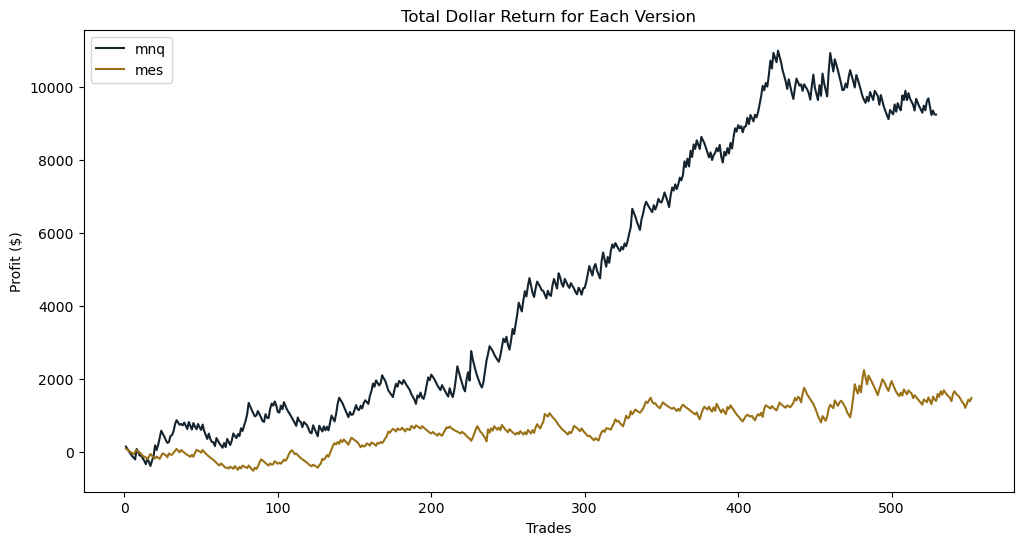

In [19]:
if asset == 'Futures':
    tickers = ['mnq','mes']
rrg.backtesting_pnl(trade_df,tickers,return_type,asset)

Clearly, MNQ is the more profitable ticker for this strategy.

## Section 8: Data Aggregation and Manipulation for Machine Learning

We will be focusing our machine learning on the first trade of the day, as factors affecting the reentry should be considered separetly. So we need to filter the dataframe down to the first trade on unique dates.

For many of these variables, like Volume of the 5' bar, it will be easier to go back up into our coding logic testing and just add the information to the trade_df directly. So let's retroactively do that. (This is where we designed all of that machine learning logic in Notebook 1)

### Variable Information:
target_label: 0 = Stopped, 1 = Profit Target  
\---------------------------------------------  
day: Multi-class categorical for day of the week the trade took place  
transaction: 0 = Short, 1 = Long  
volume_5min: Quantitiative Continous (x1000)  
volume_norm: Volume normalized to the 20 period rolling average of volume at the same timeperiod (7:30MST)  
barsize_5min: Quantitative Continuous Absolute Dollar Value (Non Directional)  
barsize_5min_norm: Quantitative Continuous Normalized as % Asset Value    
topping_tail: Quantitative Continuous Normalized as % Asset Open (top wick)  
bottoming_tail: Quantitative Continuous Normalized as % Asset Open (bottom wick)  
avwap_2day: Anchored VWAP to previous days open    
gap: Quantitative Continuous Normalized as % Asset Value  
gap_up: Categorical Binary where gapping up is the positive class (1) and gapping down is the negative class (0)

One of the features I want to have is a normalized volume over the past 20 first five minute periods. The reason why I want to do this is that volume is highly variable when you compare it across daily timeperiods and this variation will hide trends. If we look at volume on the same time period across multiple days, we want to see whether or not it is consistent, higher or lower volume. a 21 period average will be long enough to capture daily or even weekly changes (above and below average) but short enough to capture seasonal cycles (summer winter volume). In order to do this, we are going to take our MNQ OHLCV dataframe from earlier, filter based on time, add a rolling average of the volume, merge it with our ml_df based on date. Seems simple enough. Let's try it

In [21]:
#Let's create a copy of the orginal OHLCV dataframe
MNQ_vol = rrt.copy_dataframe(data_MNQ)
#Make sure we remove the date index
MNQ_vol.reset_index(inplace=True)
#Pull out the day so we can combine, let's change the name of some columns first
MNQ_vol['timestamp'] = MNQ_vol['Date']
MNQ_vol['date'] = pd.to_datetime(MNQ_vol['timestamp']).dt.date
#Let's also pull out the time so we can filter the dataframe
MNQ_vol['time'] = pd.to_datetime(MNQ_vol['timestamp']).dt.time
#Filter the dataframe
MNQ_vol = MNQ_vol[MNQ_vol['time'] == pd.to_datetime('07:30:00').time()]
#Create a new column with a rolling average of the volume for the past 20 periods
MNQ_vol['average_vol'] = MNQ_vol['Volume'].rolling(window=20).mean()
#Filter the dataframe down to something light that we can merge into the final dataframe
MNQ_vol = MNQ_vol[['date','average_vol']]

Now that we have that rolling average of volume we can start building our feature dataframe which we will call ml_df. We will combine this rolling average of data to the dataframe using 'merge' on the date. This will allow us to normalize the volume based on the rolling 20 period average. I should note here that we are only performing the machine learning on the MNQ futures contracts. This will hurt the generalizability of the algorithm but based on performance this algorithm will likely only be used on MNQ futures contracts and I want it to be as spcific to MNQ as possible. The generalizability will come from how it determines whether a trade will work or not.

In [22]:
#Create a copy of the dataframe to work with
ml_df = trade_df['mnq'].copy()
#Filter the dataframe down to only the first trade of the day for this algorithm
ml_df = ml_df.drop_duplicates(subset='date',keep='first')
#Our first transaction is also going to be dropped as we don't know the previous evenings gap price
ml_df = ml_df.iloc[1:].reset_index(drop=True)
#Time of trade entry
ml_df['time'] = ml_df['timestamp'].dt.time
#Pull out the day of the week
ml_df['day'] = ml_df['timestamp'].dt.day_name()
#Now, we can start feature engineering. Let's begin by adpting columns we already have
transaction_map = {'SHORT': 0, 'LONG': 1}
ml_df['transaction'] = ml_df['transaction'].map(transaction_map)
#Let's create our target_label for supervised learning and then drop all of our return columns
ml_df['target_label'] = np.where(ml_df['dollar_return'] > 0, 1, 0)
ml_df = ml_df.drop(columns=['compound return','absolute return',
                            'dollar_return','futures_dollar_return',
                            'futures_absolute_return','futures_compound_return',
                            'cum_dol_ret'])
#Let's merge in our rolling average of volume
ml_df = ml_df.merge(MNQ_vol, on = 'date', how = 'left')
#Let's normalize our original volume data
ml_df['volume_norm'] = ml_df['volume_5min']/ml_df['average_vol']

#Let's reorganize the Dataframe just for our convienience
ml_df = ml_df[['timestamp',
               'date',
               'time',
               'target_label',
               'day',
               'transaction',
               'volume_5min',
               'volume_norm',
               'barsize_5min',
               'barsize_5min_norm',
               'topping_tail',
               'bottoming_tail',
               'inside_wicks',
               'inside_body',
               'sma_90_norm',
               'sma_90_slope',
               'avwap_2day',
               'gap']]
ml_df['gap_up'] = np.where(ml_df['gap'] > 0,1,0)
ml_df = ml_df.dropna()

print(f"Length of dataset: {len(ml_df)}")
print(f"Current number of features: {ml_df.iloc[:,4:].shape[1]}")
ml_df.head()

Length of dataset: 360
Current number of features: 15


,timestamp,date,time,target_label,day,transaction,volume_5min,volume_norm,barsize_5min,barsize_5min_norm,topping_tail,bottoming_tail,inside_wicks,inside_body,sma_90_norm,sma_90_slope,avwap_2day,gap,gap_up
17,2023-12-13 07:35:00,2023-12-13,07:35:00,0,Wednesday,1.0,29617.0,0.870826,40.0,0.23,0.0072,0.0217,0.0,1.0,1.0132,0.0228,0.045,1.01,1
18,2023-12-14 07:40:00,2023-12-14,07:40:00,0,Thursday,1.0,29997.0,0.882998,47.75,0.27,0.0686,0.0529,0.0,0.0,1.0118,0.028,0.1056,0.24,1
19,2023-12-15 07:35:00,2023-12-15,07:35:00,0,Friday,1.0,32782.0,0.980852,39.75,0.23,0.1518,0.0458,1.0,1.0,1.0018,-0.0007,0.1322,0.19,1
20,2023-12-18 07:35:00,2023-12-18,07:35:00,1,Monday,1.0,31228.0,0.930532,41.0,0.23,0.04,0.087,0.0,1.0,1.0015,0.0088,0.0112,0.16,1
21,2023-12-19 07:40:00,2023-12-19,07:40:00,1,Tuesday,1.0,32376.0,0.964989,44.75,0.25,0.0766,0.0482,1.0,0.0,1.0023,0.0099,0.0865,0.09,1


 So, let's export the MNQ data to a CSV file that we can use for future machine learning analysis. Before we close this out, there is one more feature we want for our machine learning. So let's save this to the data here.

In [23]:
#Export data to a csv file
ml_df.to_csv('mnq_backtesting_data.csv')